In [1]:
library(vcfR)
vcf <- read.vcfR("~/populationgenomics/data/vcf/chr2_135_145.vcf.gz")


   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****




Scanning file to determine attributes.
File attributes:
  meta lines: 47
  header_line: 48
  variant count: 49868
  column count: 37
Meta line 47 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 49868
  Character matrix gt cols: 37
  skip: 0
  nrows: 49868
  row_num: 0
Processed variant: 49868
All variants processed


Here we extract some fields from the VCF that might be of usage when doing some QC analysis. We caan extract per position variables (info fields), e.g:

- TR : Total number of reads containing this variant.

Or per position and per sample variables (format fields), e.g:
- GT : genotype.
- GQ : genotype quality.
- NR : number of reads covering variant location in this sample.

Inspect the VCF file header to select other variables of interest. Here, we are only going to use the genotypes.

In [2]:
library(dplyr)
tvcf <- vcfR2tidy(vcf, 
          single_frame = TRUE,
          info_fields = c("TR"),
          format_fields = c("GT","GQ","NR"),
          info_types = TRUE,
          format_types = c(NR="i",GQ="i"))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Extracting gt element GT

Extracting gt element GQ

Extracting gt element NR



We add the metadata containing the population and region of each sample. We also convert heterozygouss genotypes to a common format. When we have phased data (next week), we know the parental and maaternal haplotypes and the order of 1 and 0, determines these haplotypes. Phased data is represented with "|" instead of "/". In this case, we have unphased data, but the algorithm might have randomly ordered the alleles, and we are only interested in the fact that they are heterozygous, thus we simplify the analysis by using a common representation.

In [3]:
info <- read.csv2("~/populationgenomics/data/metadata/sample_infos_accessionnb.csv")
d <- inner_join(tvcf$dat,info, by= c("Indiv" = "ENA.RUN")) %>%
  mutate(gt_GT=replace(gt_GT, gt_GT=="1/0", "0/1"))

## PART I

We start the analysis by looking at the proportion of missing genotypes for each sample.

In [4]:
d %>% 
  group_by(Indiv) %>%
  summarise(missing = mean(is.na(gt_GT))) %>%
  arrange(desc(missing))

Indiv,missing
<chr>,<dbl>
ERR1025639,1.0000000000
ERR1019039,0.0018448705
ERR1019075,0.0014438117
ERR1025624,0.0013836528
ERR1025598,0.0012232293
ERR1025657,0.0011029117
ERR1019076,0.0010026470
ERR1025610,0.0010026470
ERR1025658,0.0009424882


We find one individual that only has missing genotypes. This tells us that either there was no sequencing data for this sindividual, or that it was of poor quality and the alignment of the reads was completely unsuccesful.  

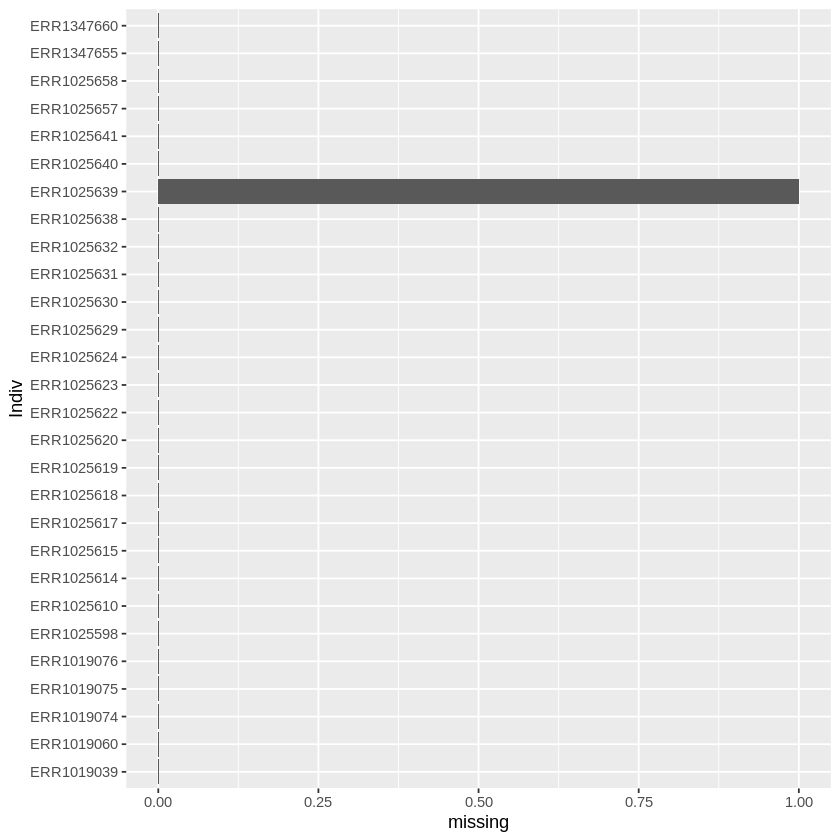

In [5]:
library(ggplot2)
d %>% 
  group_by(Indiv) %>%
  summarise(missing = mean(is.na(gt_GT))) %>%
  ggplot(aes(x=Indiv,y=missing)) + geom_col() + coord_flip()

In [6]:
d <- d %>% filter(Indiv!="ERR1025639")

#### Q1. Which individual has the largest amount of missing data now?

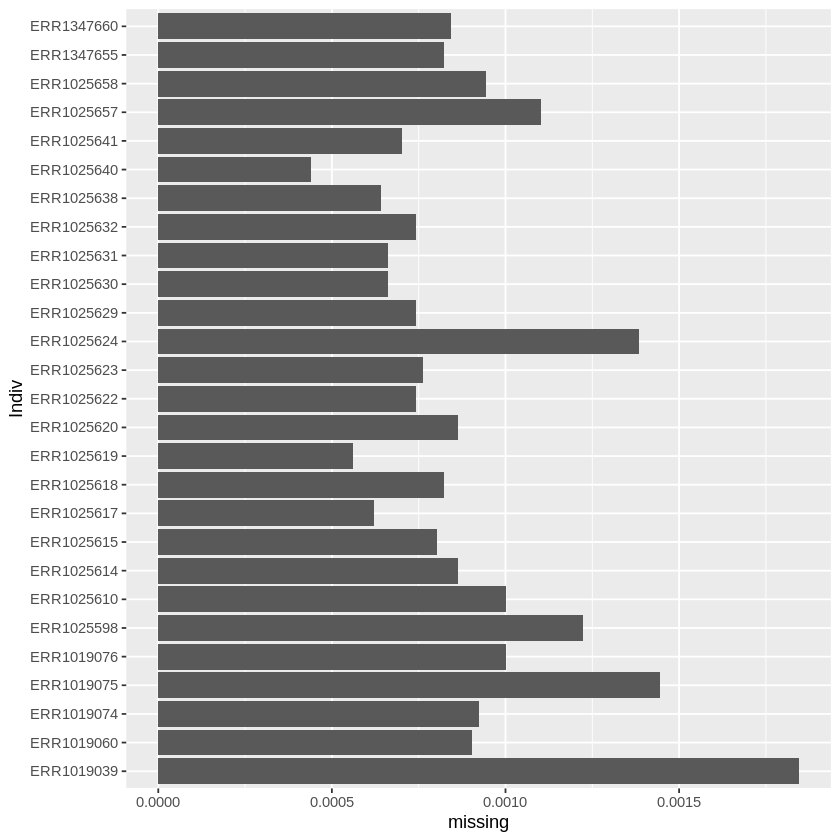

In [7]:
d %>% 
  group_by(Indiv) %>%
  summarise(missing = mean(is.na(gt_GT))) %>%
  ggplot(aes(x=Indiv,y=missing)) + geom_col() + coord_flip()

Missing data is a sign of poor quality. It can be representative of poor sample quality or variant quality. Genotype algorithms generally include a set of variables and thresholding points to distinguish low quality variants from the rest. This is represented in the FILTER column. Generally, depending on your experiment, you would like to define your own quality filters, but is an informative start. 

In order to know the metrics used to define the FILTER column, you can inspect the header of the VCF file. In this case, we have the following:


FILTER=<ID=GOF,Description="Variant fails goodness-of-fit test.">

FILTER=<ID=badReads,Description="Variant supported only by reads with low quality bases close to variant position, and not present on both strands.">

FILTER=<ID=alleleBias,Description="Variant frequency is lower than expected for het">

FILTER=<ID=hp10,Description="Flanking sequence contains homopolymer of length 10 or greater">

FILTER=<ID=Q20,Description="Variant quality is below 20.">

FILTER=<ID=HapScore,Description="Too many haplotypes are supported by the data in this region.">

FILTER=<ID=MQ,Description="Root-mean-square mapping quality across calling region is low.">

FILTER=<ID=strandBias,Description="Variant fails strand-bias filter">

FILTER=<ID=SC,Description="Variants fail sequence-context filter. Surrounding sequence is low-complexity">

FILTER=<ID=QualDepth,Description="Variant quality/Read depth ratio is low.">

FILTER=<ID=REFCALL,Description="This line represents a homozygous reference call">

FILTER=<ID=QD,Description="Variants fail quality/depth filter.">


If we have any of these ID parameters, the variant does not pass the FILTER, and the ID indicates us why. Conversely, if the variant has a "PASS" on the FILTER column, it has passed these filters.

#### Q2. Some variants have values different from "PASS" in the FILTER column. These variants should be removed. Does that change the fraction of missing data?

In [8]:
d <- d %>% filter(FILTER=="PASS")

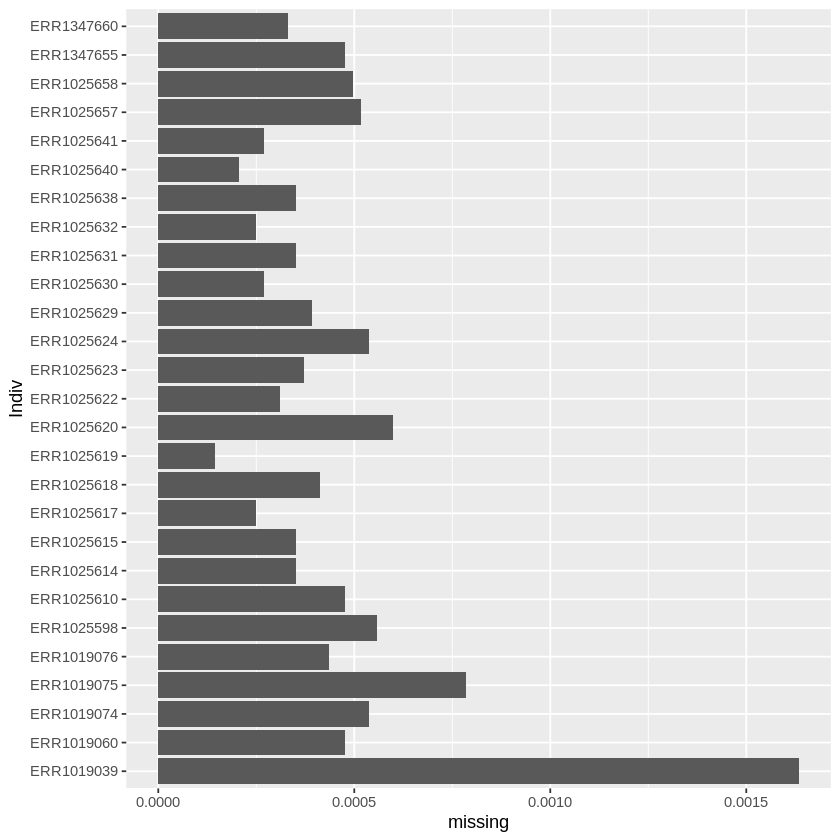

In [9]:
d %>% 
  group_by(Indiv) %>%
  summarise(missing = mean(is.na(gt_GT))) %>%
  ggplot(aes(x=Indiv,y=missing)) + geom_col() + coord_flip()

#### Q3. The column gt_NR contains the number of reads covering the position. What is the average depth in the data set?

In [10]:
mean(d$gt_NR)

[1] 37.38623

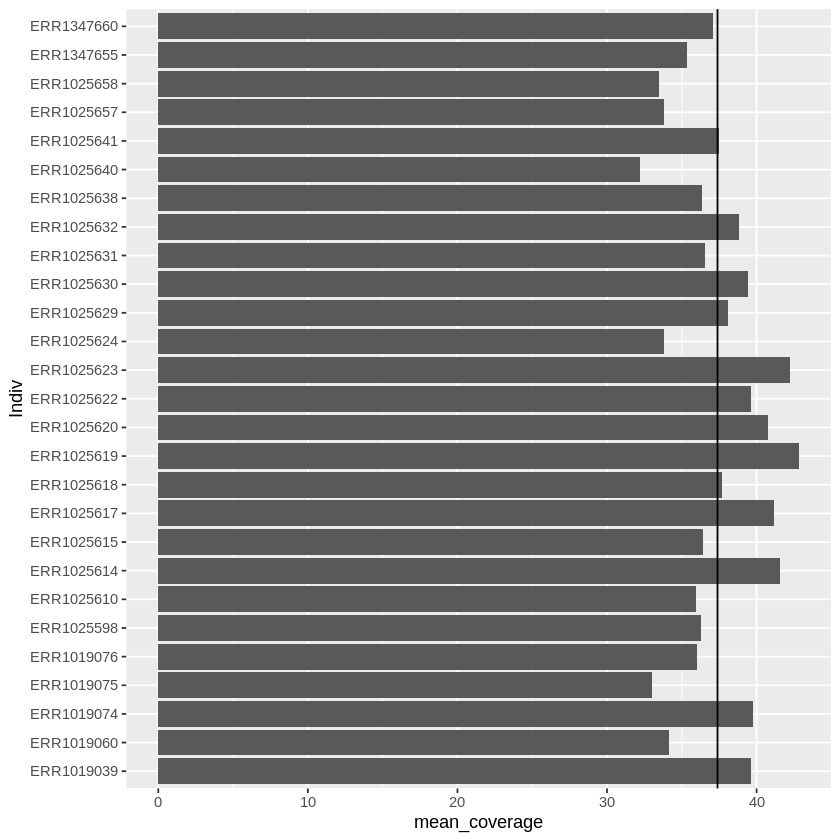

In [11]:
d %>% 
    group_by(Indiv) %>%
    summarise(mean_coverage = mean(gt_NR)) %>%
    ggplot(aes(x=Indiv,y=mean_coverage)) + geom_col() + geom_hline(yintercept = mean(d$gt_NR)) + coord_flip() 

"We sequenced the samples to an average coverage of 43-fold (range 34–83-fold) at Illumina Ltd; almost all samples (278) were prepared using the same PCR-free library preparation" https://www.nature.com/articles/nature18964

#### Q4. If a variant is heterozygous the gt_GT variable will have the value "0/1". Make a plot of the number of variants that are heterozygous for each individual. Which population has the highest fraction of heterozygous variants in this genomic region?

In [12]:
names(d)

[1] "CHROM"         "POS"           "ID.x"          "REF"          
 [5] "ALT"           "QUAL"          "FILTER"        "TR"           
 [9] "Indiv"         "gt_GT"         "gt_GQ"         "gt_NR"        
[13] "gt_GT_alleles" "ID.y"          "population"    "region"       
[17] "country"       "latitude"      "longitude"     "Sex"          
[21] "Illumina.ID"

`summarise()` has grouped output by 'Indiv'. You can override using the `.groups` argument.



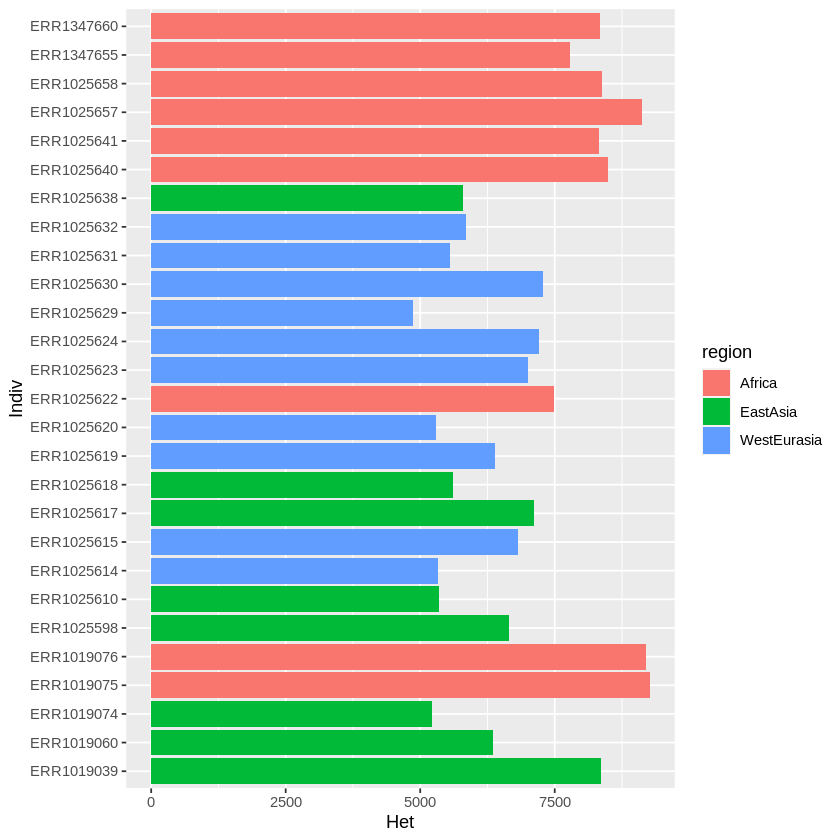

In [13]:
d %>% 
    filter(! is.na(gt_GT)) %>%
    group_by(Indiv,region) %>%
    summarise(Het = sum(gt_GT == "0/1")) %>%
    ggplot(aes(x=Indiv,y=Het, fill=region)) + geom_col() + coord_flip() 

## PART II

Here we define the frequencies of each allele for each variant on each region.

In [14]:
d2 <- d %>%
  group_by(POS,region) %>%
  summarise(na=sum(gt_GT=="0/1",na.rm=T)+2*sum(gt_GT=="0/0",na.rm=T),
            nA=sum(gt_GT=="0/1",na.rm=T)+2*sum(gt_GT=="1/1",na.rm=T))  %>%
  mutate(pS=na/(na+nA), qS= nA/(na+nA))

`summarise()` has grouped output by 'POS'. You can override using the `.groups` argument.



Here we plot the positions with polymoprhism for each region. As expected, Africa is the region with the highest polymorphism.

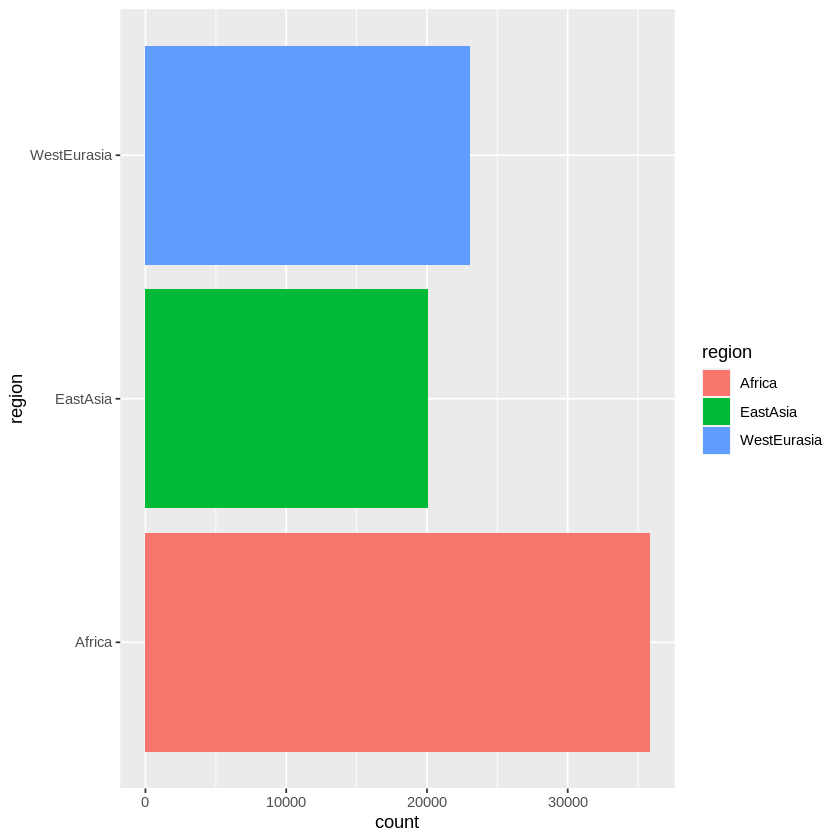

In [15]:
d2 %>% 
  filter(na!=0, nA!=0) %>%
  ggplot(aes(x=region, fill=region)) + geom_bar() + coord_flip()

In [16]:
d2

POS,region,na,nA,pS,qS
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
135000277,Africa,14,4,0.7777778,0.22222222
135000277,EastAsia,16,0,1.0000000,0.00000000
135000277,WestEurasia,20,0,1.0000000,0.00000000
135000500,Africa,16,2,0.8888889,0.11111111
135000500,EastAsia,10,6,0.6250000,0.37500000
135000500,WestEurasia,4,16,0.2000000,0.80000000
135000674,Africa,3,15,0.1666667,0.83333333
135000674,EastAsia,4,12,0.2500000,0.75000000
135000674,WestEurasia,2,18,0.1000000,0.90000000


#### Q5. Use `d2` from above to calculate `FST` for each position. What is the median FST value?

In [31]:
median((d2 %>%
    #filter(na!=0, nA!=0) %>%
    group_by(POS) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)))$FST)

[1] 0.04255319

#### Q6. Make a histogram of the `FST` values

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



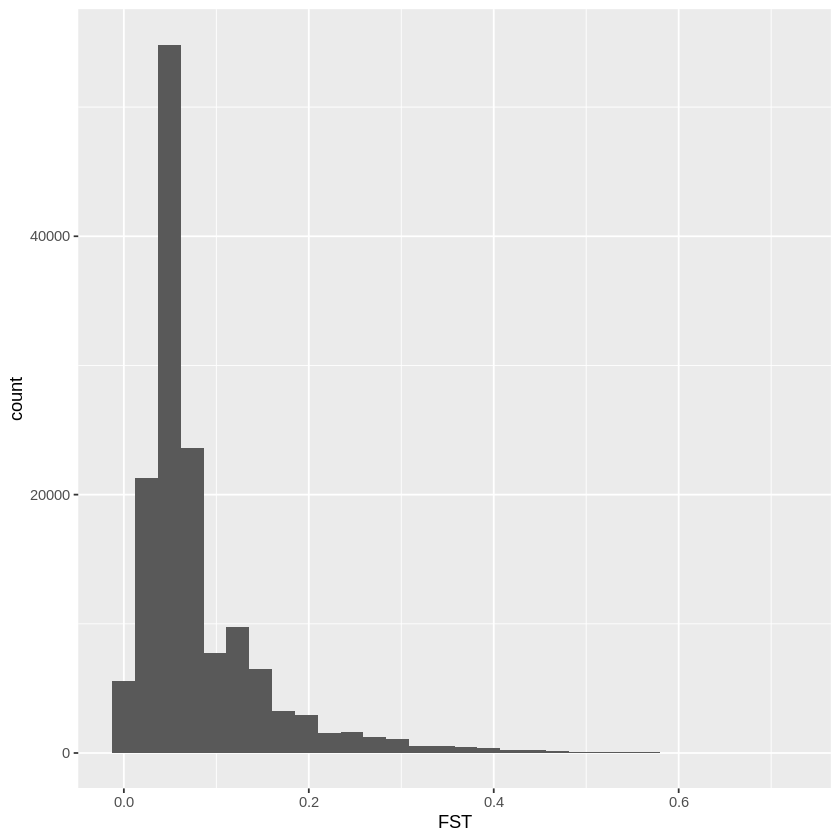

In [18]:
d2 %>%
    #filter(na!=0, nA!=0) %>%
    group_by(POS) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)) %>%
    ggplot() + geom_histogram(aes(x=FST))

#### Q.7 Calculate `FST` using only the European and African samples and make a histogram of the values.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



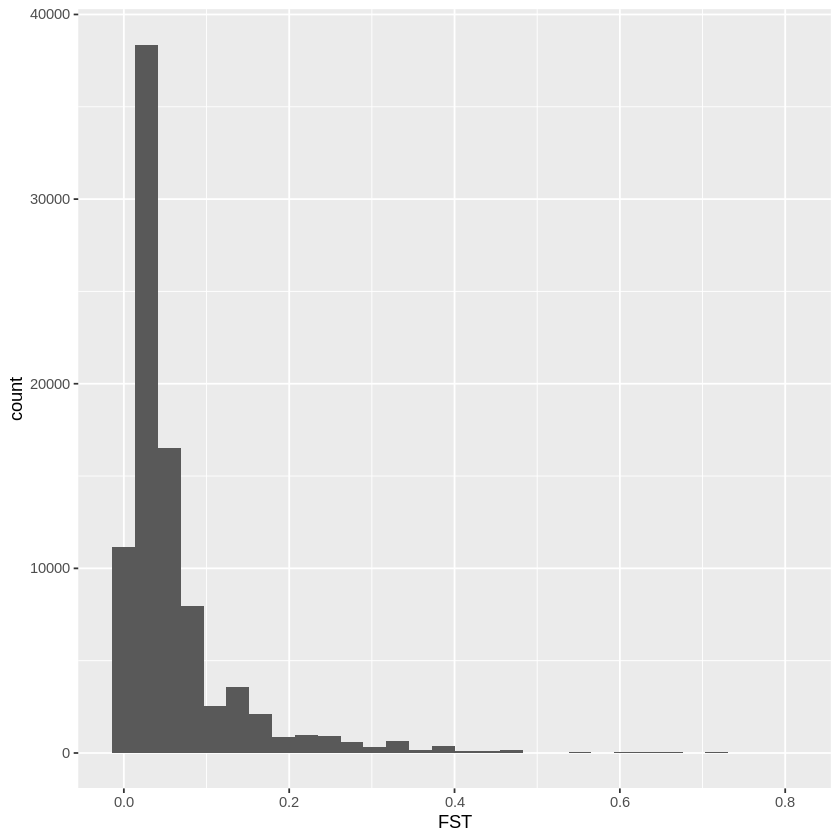

In [19]:
d2 %>%
    filter(region %in% c("WestEurasia","Africa")) %>%
    group_by(POS) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)) %>%
    ggplot() + geom_histogram(aes(x=FST))

#### Q.8 Make a plot with the genomic position on the x axis and the `FST` value on the y axis. (Hint: use geom_point() or geom_line())

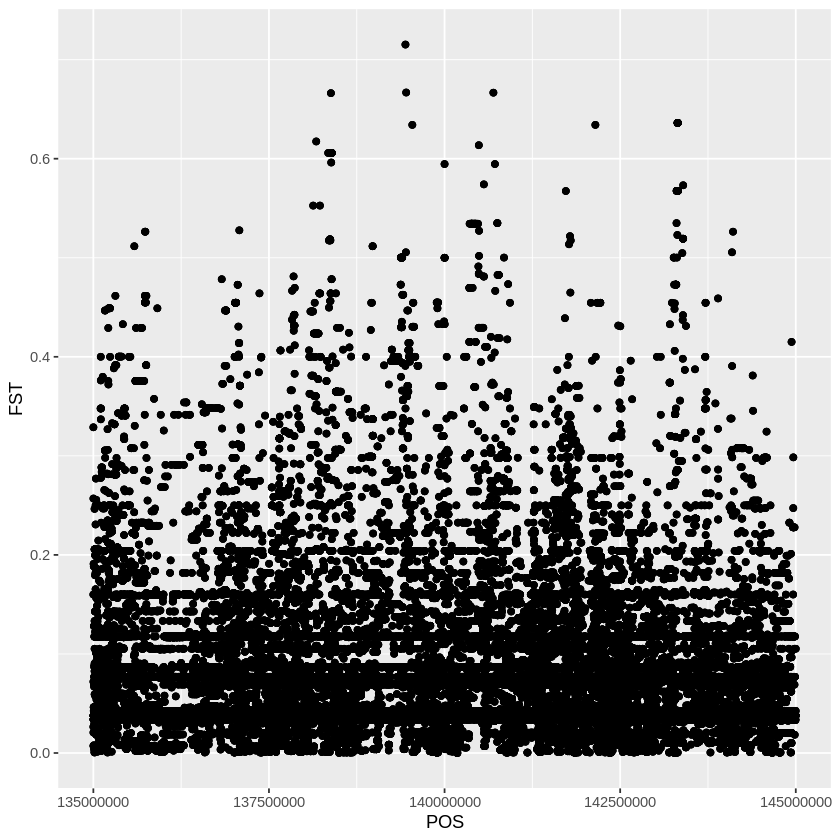

In [20]:
d2 %>%
    group_by(POS) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)) %>%
    ggplot() + geom_point(aes(x=POS,y=FST))

#### Q.9 Make a plot with average FST in bins along the genome.

`summarise()` has grouped output by 'binmid'. You can override using the `.groups` argument.



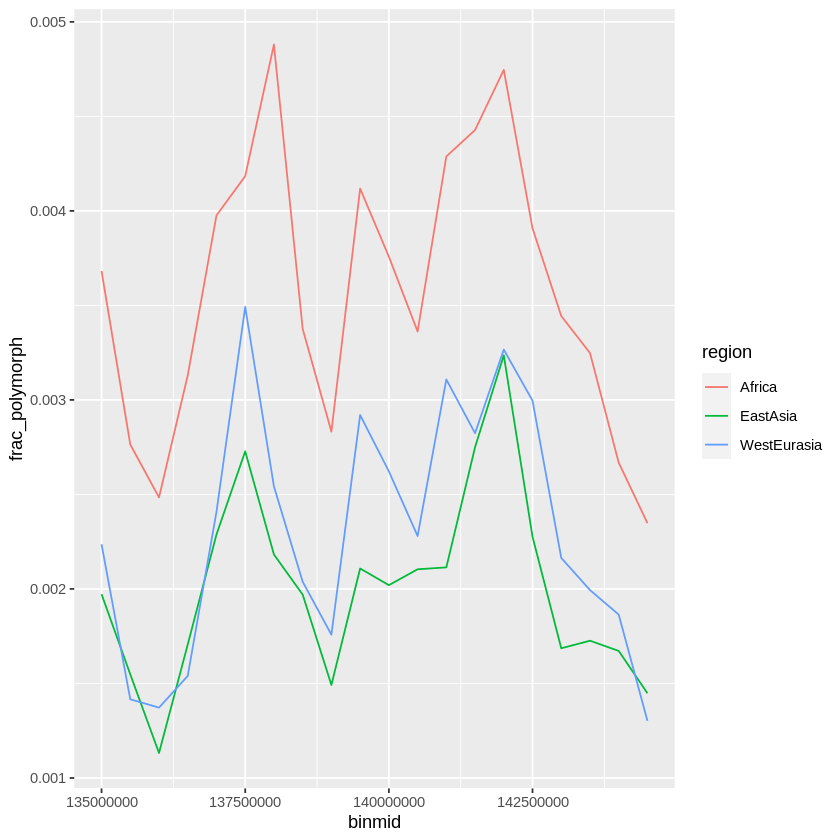

In [21]:
bin_width = 500000
d2 %>% 
  mutate(binmid=((POS %/% bin_width)*bin_width)) %>%
  filter(na!=0, nA!=0) %>%
  group_by(binmid, region) %>%
  summarise(frac_polymorph=n()/bin_width) %>%
  ggplot(aes(x=binmid, y=frac_polymorph, color=region)) + geom_line()

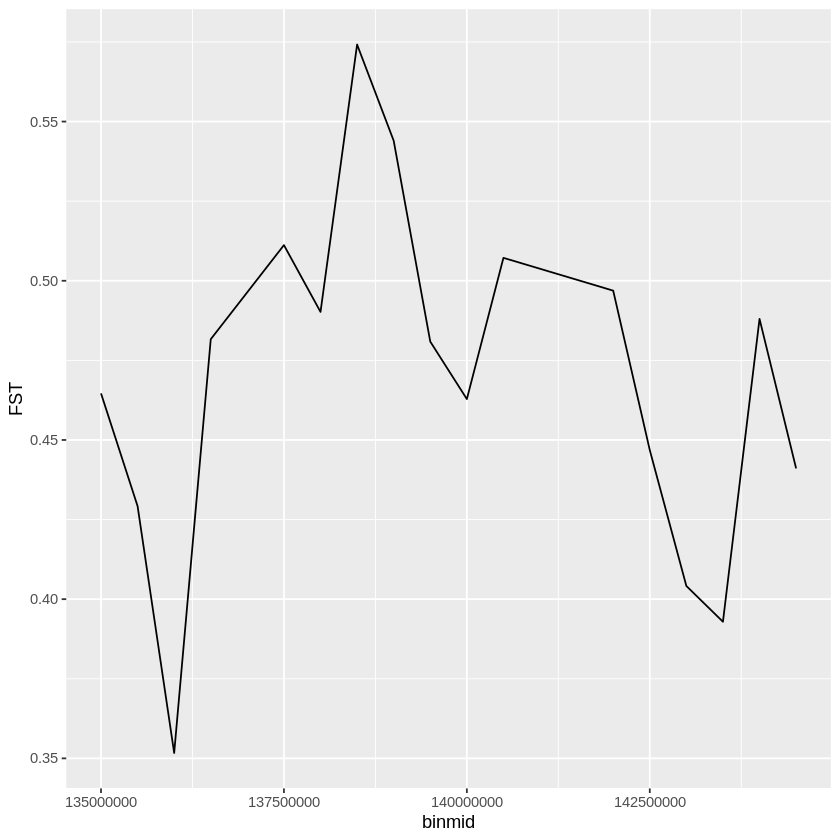

In [22]:
bin_width = 500000
d2 %>% 
    mutate(binmid=((POS %/% bin_width)*bin_width)) %>%
    group_by(binmid) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)) %>%
    ggplot() + geom_line(aes(x=binmid,y=FST))

In [23]:
d2 %>% 
    filter(region %in% c("WestEurasia","Africa")) %>%
    mutate(binmid=((POS %/% bin_width)*bin_width)) %>%
    group_by(binmid) %>%
    mutate(H_S = mean(2*pS*qS)) %>%
    mutate(H_T = 2*mean(pS)*mean(qS)) %>%
    mutate(FST = 1- (H_S/H_T)) %>%
    filter(!is.na(FST)) %>% 
    arrange(desc(FST)) %>%
    select(FST,binmid) %>%
    head(1)

FST,binmid
<dbl>,<dbl>
0.5386229,138500000
